In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler,OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
data= pd.read_csv("Bank Customer Churn Prediction.csv")

In [4]:
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Missing Value Report

In [5]:
x= pd.DataFrame(data.isnull().sum())
x

,0
customer_id,0
credit_score,0
country,0
gender,0
age,0
tenure,0
balance,0
products_number,0
credit_card,0
active_member,0


## Continous Feature Report


In [6]:
numeric_features= data.select_dtypes(include=[np.number])

In [8]:
def build_continuous_features_report(data_df):
    
    """Build tabular report for continuous features"""

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Min": lambda df: df.min(),
        "1st Qrt.": lambda df: df.quantile(0.25),
        "Mean": lambda df: df.mean(),
        "Median": lambda df: df.median(),
        "3rd Qrt": lambda df: df.quantile(0.75),
        "Max": lambda df: df.max(),
        "Std. Dev.": lambda df: df.std(),
    }

    contin_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[contin_feat_names]

    report_df = pd.DataFrame(index=contin_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

In [9]:
build_continuous_features_report(numeric_features)

,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
customer_id,10000,0.0,10000,15565701.00,15628528.25,1.569094e+07,1.569074e+07,1.575323e+07,15815690.00,71936.186123
credit_score,10000,0.0,460,350.00,584.00,6.505288e+02,6.520000e+02,7.180000e+02,850.00,96.653299
age,10000,0.0,70,18.00,32.00,3.892180e+01,3.700000e+01,4.400000e+01,92.00,10.487806
tenure,10000,0.0,11,0.00,3.00,5.012800e+00,5.000000e+00,7.000000e+00,10.00,2.892174
balance,10000,0.0,6382,0.00,0.00,7.648589e+04,9.719854e+04,1.276442e+05,250898.09,62397.405202
products_number,10000,0.0,4,1.00,1.00,1.530200e+00,1.000000e+00,2.000000e+00,4.00,0.581654
credit_card,10000,0.0,2,0.00,0.00,7.055000e-01,1.000000e+00,1.000000e+00,1.00,0.455840
active_member,10000,0.0,2,0.00,0.00,5.151000e-01,1.000000e+00,1.000000e+00,1.00,0.499797
estimated_salary,10000,0.0,9999,11.58,51002.11,1.000902e+05,1.001939e+05,1.493882e+05,199992.48,57510.492818
churn,10000,0.0,2,0.00,0.00,2.037000e-01,0.000000e+00,0.000000e+00,1.00,0.402769


## Categotical Features Report

In [18]:
categorical_features = data.select_dtypes(include=[object])

In [19]:
categorical_features.columns

Index(['country', 'gender'], dtype='object')

In [25]:
def build_categorical_features_report(data_df):
    """Build tabular report for categorical features"""

    def _mode(df):
        return df.mode().to_list()

    def _mode_freq(df):
        return df.value_counts()[df.mode()].sum()

    def _second_mode(df):
        return df[~df.isin(df.mode())].mode().to_list()

    def _second_mode_freq(df):
        return df[~df.isin(df.mode())].value_counts()[df[~df.isin(df.mode())].mode()].sum()

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Mode": _mode,
        "Mode Freq": _mode_freq,
        "Mode %": lambda df: _mode_freq(df) / len(df) * 100,
        "2nd Mode": _second_mode,
        "2nd Mode Freq": _second_mode_freq,
        "2nd Mode %": lambda df: _second_mode_freq(df) / len(df) * 100,
    }

    cat_feat_names = data_df.select_dtypes(exclude="number").columns
    report_df = pd.DataFrame(index=cat_feat_names, columns=stats.keys())

    for col in cat_feat_names:
        for stat_name, fn in stats.items():
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                report_df.loc[col, stat_name] = fn(data_df[col])

    return report_df


In [26]:

build_categorical_features_report(categorical_features)

,Count,Miss %,Card.,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %
country,10000,0.0,3,[France],5014,50.14,[Germany],2509,25.09
gender,10000,0.0,2,[Male],5457,54.57,[Female],4543,45.43


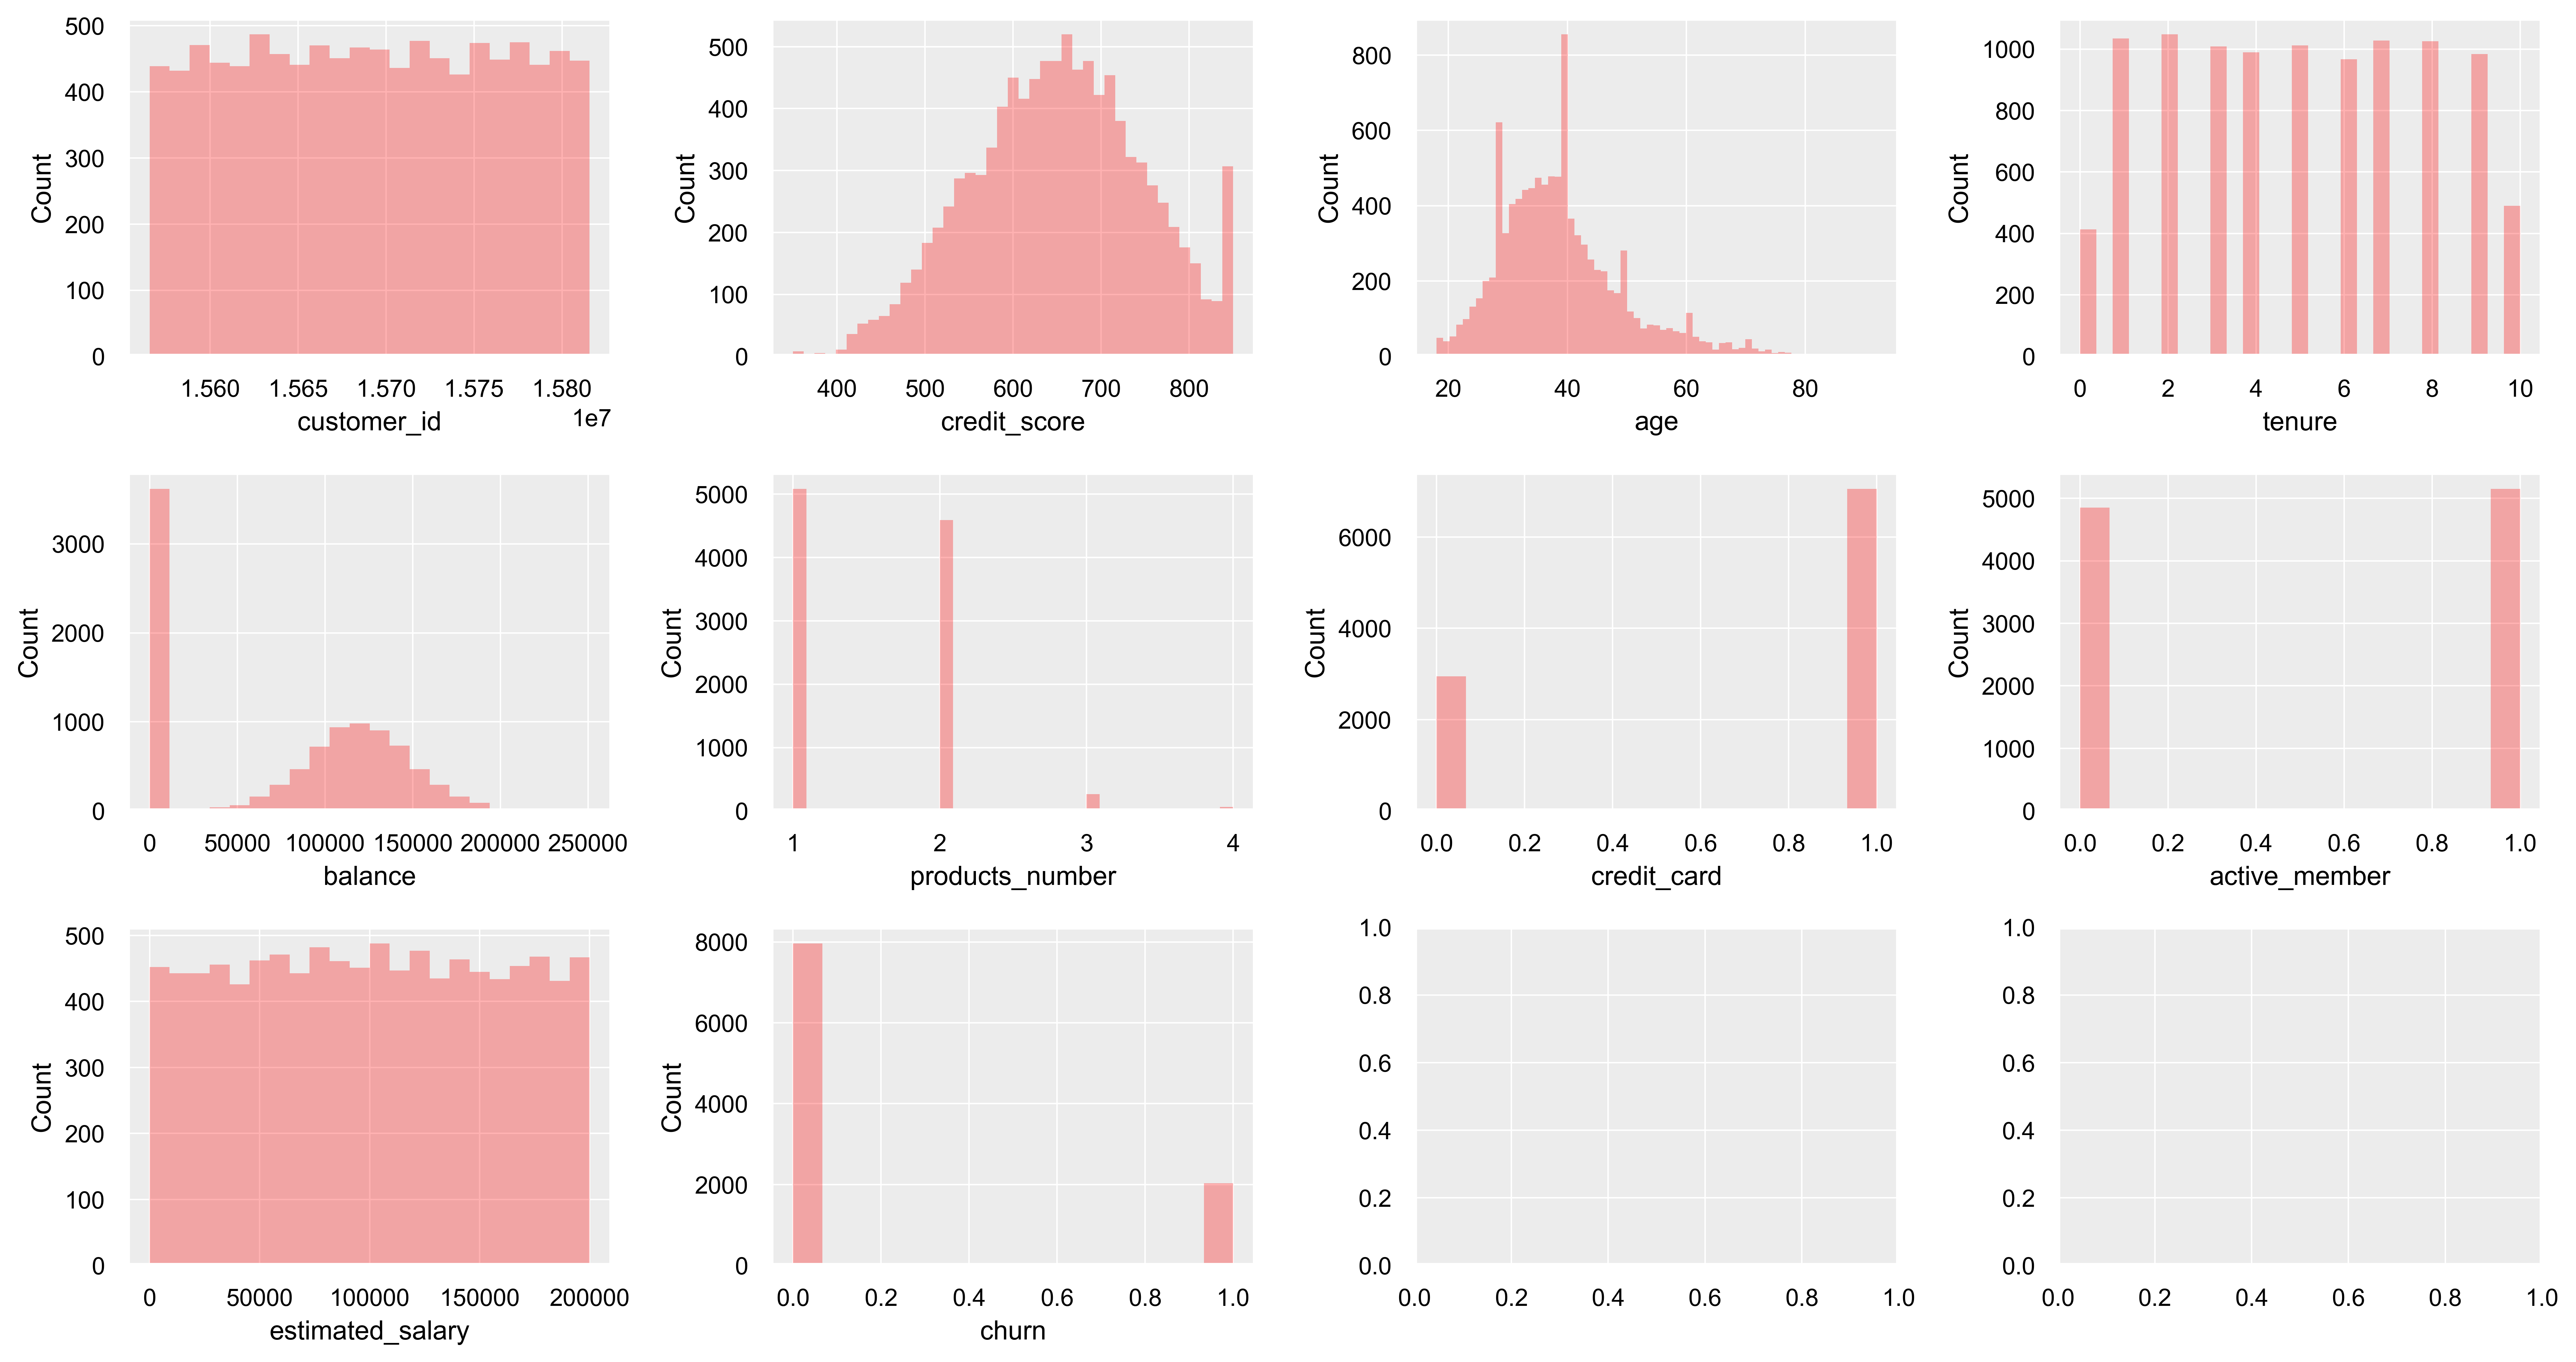

In [34]:
sns.set_theme(rc={'grid.linewidth': 0.6, 'grid.color': 'white',
                  'axes.linewidth': 2, 'axes.facecolor': '#ECECEC',
                  'axes.labelcolor': '#000000',
                  'figure.facecolor': 'white',
                  'xtick.color': '#000000', 'ytick.color': '#000000'})

with plt.rc_context(rc={'figure.dpi': 500, 'axes.labelsize': 11,
                        'xtick.labelsize': 10, 'ytick.labelsize': 10}):
    fig, axes = plt.subplots(3, 4, figsize=(15, 8))
    ax_flat = axes.flatten()

    for idx, (col, ax) in enumerate(zip(numeric_features, ax_flat)):
      sns.histplot(ax=ax, x=data[col], color='red', alpha=0.3, linewidth=0)

      [axes.set_visible(False) for axes in ax_flat[len(numeric_features):]]

    plt.tight_layout(pad=1)
    plt.show()

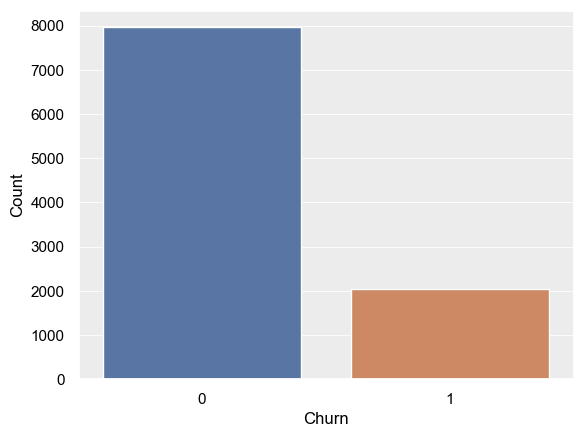

In [46]:
churn_counts = data['churn'].value_counts()
sns.barplot(x=churn_counts.index, y=churn_counts.values)
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

The target variable Churn is not balanced. Hence we will pefrom SMOTE for the triaing dataset to prevet the model from getting biased


## Feature Enginerring and Data Split

In [59]:
X = data.drop(columns=['churn'])
y = data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [64]:
continuous_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(exclude=[np.number]).columns

X_train_continuous = X_train[continuous_features]
X_test_continuous = X_test[continuous_features]
X_train_categorical = X_train[categorical_features]
X_test_categorical = X_test[categorical_features]

In [65]:
#####Standardization

scaler= StandardScaler()
X_train_continuous= scaler.fit_transform(X_train_continuous)
X_test_continuous= scaler.fit_transform(X_test_continuous)

In [70]:
####One hot encoding
encoder= OneHotEncoder(drop='first', sparse=False)

X_train_categorical= encoder.fit_transform(X_train_categorical)
X_test_categorical= encoder.fit_transform(X_test_categorical)

X_train_processed = np.hstack((X_train_continuous, X_train_categorical))
X_test_processed = np.hstack((X_test_continuous, X_test_categorical))

In [71]:
## Smote for Handling the Unbalancedd Data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)


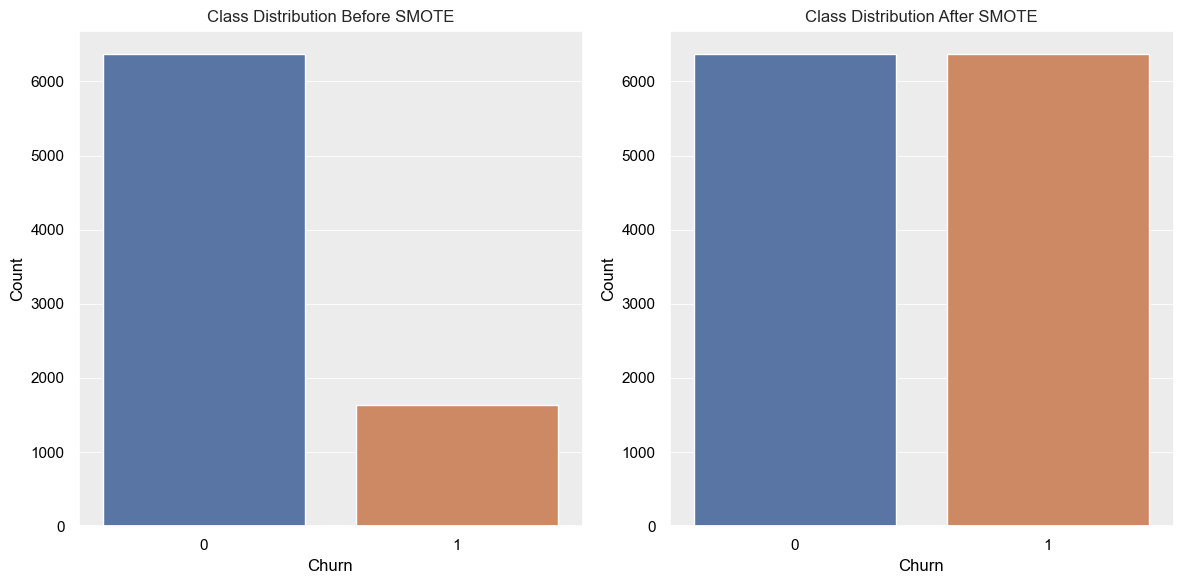

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title('Class Distribution Before SMOTE')
ax[0].set_xlabel('Churn')
ax[0].set_ylabel('Count')
sns.countplot(x=y_train_smote, ax=ax[1])
ax[1].set_title('Class Distribution After SMOTE')
ax[1].set_xlabel('Churn')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


Now the class imbalance of target varaible is removed from the training data we can train our baseline model



## Baseline Models

In [89]:
RF_base = RandomForestClassifier(random_state=42)
RF_base.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [93]:
xgb_base=xgb.XGBClassifier(random_state=42)
xgb_base.fit(X_train_smote,y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [88]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

def eval_metric(model, X_test, y_test):
    """
    Evaluate the performance of a model.
    
    Parameters:
    - model: The trained model to evaluate.
    - X_test: Test set features.
    - y_test: True labels for the test set.
    
    Returns:
    - None
    """
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Classification Report
    cr = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(cr)
    
    # ROC AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("ROC AUC Score:", roc_auc)
    


In [95]:
eval_metric(RF_base, X_test_processed, y_test)


Confusion Matrix:
[[1404  189]
 [ 155  252]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1593
           1       0.57      0.62      0.59       407

    accuracy                           0.83      2000
   macro avg       0.74      0.75      0.74      2000
weighted avg       0.83      0.83      0.83      2000

ROC AUC Score: 0.8237767814039


In [96]:
eval_metric(xgb_base, X_test_processed, y_test)

Confusion Matrix:
[[ 408 1185]
 [  50  357]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.26      0.40      1593
           1       0.23      0.88      0.37       407

    accuracy                           0.38      2000
   macro avg       0.56      0.57      0.38      2000
weighted avg       0.76      0.38      0.39      2000

ROC AUC Score: 0.6569096060621484


We have got the results from the baseline models. The randomforest seems to classify better compared to XGBoost model. Now we will tune the hyperparametes and compare which model classifies better

## HyperParametr Tuning


Hyperparamter tuning for Random Forest

In [104]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote)

# Best parameters from GridSearch
print("Best parameters found: ", grid_search.best_params_)

# Train the best model
best_model = grid_search.best_estimator_

# Cross-validation scores on training data
cv_scores = cross_val_score(best_model, X_train_smote, y_train_smote, cv=5, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cv_scores)
print("Mean ROC AUC score:", np.mean(cv_scores))

# Fit the best model on the entire training data
best_model.fit(X_train_smote, y_train_smote)

# Final evaluation on the test data
eval_metric(best_model, X_test_processed, y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Cross-validation ROC AUC scores: [0.91648142 0.96886344 0.99003066 0.98677295 0.99014248]
Mean ROC AUC score: 0.9704581917297773
Confusion Matrix:
[[1395  198]
 [ 153  254]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1593
           1       0.56      0.62      0.59       407

    accuracy                           0.82      2000
   macro avg       0.73      0.75      0.74      2000
weighted avg       0.83      0.82      0.83      2000

ROC AUC Score: 0.8235909252858405


In [103]:
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.5, 1, 1.5]
}


xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train_smote, y_train_smote)

print("Best parameters found for XGBoost: ", grid_search_xgb.best_params_)

best_xgb_model = grid_search_xgb.best_estimator_

cv_scores_xgb = cross_val_score(best_xgb_model, X_train_smote, y_train_smote, cv=5, scoring='roc_auc')
print("XGBoost Cross-validation ROC AUC scores:", cv_scores_xgb)
print("XGBoost Mean ROC AUC score:", np.mean(cv_scores_xgb))

best_xgb_model.fit(X_train_smote, y_train_smote)
eval_metric(best_xgb_model, X_test_processed, y_test)

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
Best parameters found for XGBoost:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'subsample': 0.8}
XGBoost Cross-validation ROC AUC scores: [0.88512614 0.96864903 0.99439398 0.99321227 0.99391156]
XGBoost Mean ROC AUC score: 0.9670585973792971
Confusion Matrix:
[[758 835]
 [ 76 331]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.48      0.62      1593
           1       0.28      0.81      0.42       407

    accuracy                           0.54      2000
   macro avg       0.60      0.64      0.52      2000
weighted avg       0.78      0.54      0.58      2000

ROC AUC Score: 0.7374462289716527


In [106]:

with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

###For loading
#with open('best_xgb_model.pkl', 'rb') as f:
    #loaded_model = pickle.load(f)

In [107]:
with open('best_RF_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [119]:
importances = best_model.feature_importances_
importances

array([0.0792238 , 0.07721381, 0.23634276, 0.06824852, 0.10194219,
       0.13091525, 0.01272886, 0.03283865, 0.08012248, 0.07705387,
       0.03823533, 0.06513449])

In [120]:
feature_names

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary'],
      dtype='object')

In [118]:
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature':feature_names, 'importance': importances})


ValueError: All arrays must be of the same length

In [109]:
feature_importances = best_model.feature_importances_

# Get feature names (assuming you have already combined them as in previous examples)
feature_names = np.hstack((continuous_features, encoder.get_feature_names_out(categorical_features)))

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

ValueError: input_features should have length equal to number of features (3), got 2